<i>Based on code by Alexandre Nesovic

<h2>S&P500 index</h2>


In this example, we use the S&P500 index and along with its constituent stocks. We cluster the stocks based on the average return and volatility. We apply Principal component analysis and compare the first principal component PC1 with the S&P500 index. We look how well PC1 tracks the index. Based on PC1, we try to form a winning portfolio. 

In [3]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 24.1 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=268032 sha256=b41fb6c569bd7f719984f566f12beaf691f22b6a2d3ade413fc1d375803f7e98
  Stored in directory: /home/turnas1/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

Choose a time period. Download S&P500 index (SPY) from Yahoo Finance

In [5]:
start_date = '2023-09-05'
end_date = '2024-03-05'

In [6]:
prices_SPY = yf.download(['SPY'], start=start_date, end=end_date)['Adj Close'] 

[*********************100%%**********************]  1 of 1 completed


Download S&P500 tickers from Wikipedia to 'tables'. Then, download the corresponding stock adjusted closing prices from Yahoo Finance. 

In [7]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
sp500_table = tables[0]
sp500_tickers = sp500_table['Symbol'].tolist()

print(sp500_tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DH

In [8]:
prices = yf.download(sp500_tickers, start=start_date, end=end_date)['Adj Close'] 

[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-09-05 -> 2024-03-05)')


Compute the log-returns rs.
Then, compute the returns (the percentage change), the average returns and the volatilities.


In [9]:
rs = prices.apply(np.log).diff(1)
rs=rs.fillna(0)

returns=prices.pct_change(fill_method=None)
average_returns=returns.mean()
volatility=rs.std()*252 
volatility.head()

Ticker
A       4.442753
AAL     6.356351
AAPL    2.953490
ABBV    2.561299
ABNB    5.667505
dtype: float64

In [10]:
rv = np.column_stack((average_returns, volatility))
rv = np.nan_to_num(rv)

<h4>KMeans clustering </h4>

From sklearn, import KMeans. Then, Compute k-means clustering for 'rv'. The number of clusters can be 4. the cluster centers can be extracted via  '.cluster_centers_'

In [11]:
from sklearn.cluster import KMeans
 
starting_centroids = np.array([[-1.42079379e-03,  1.11486490e+01],
       [ 1.19461915e-05,  4.01719249e+00],
       [-2.74353027e-04,  7.48526758e+00],
       [-3.28330330e-04,  5.47369239e+00]])

km_res = KMeans(n_clusters=4, n_init='auto', init = starting_centroids).fit(rv)
clusters = km_res.cluster_centers_
 

Draw a scatter plot of the average_returns and volatility. Plot also the cluster centroids.

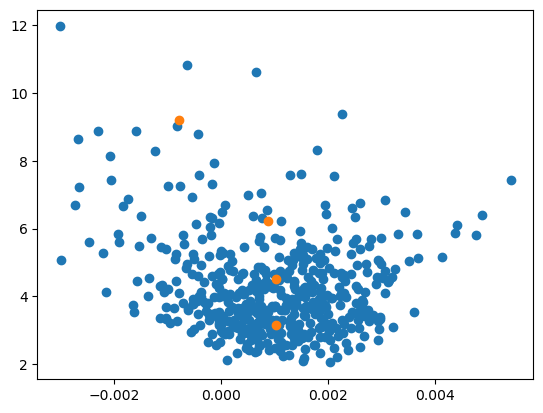

In [12]:
plt.scatter(average_returns, volatility)
plt.scatter(clusters[:,0], clusters[:,1])

Define and print the labels of each point

In [13]:
labels = km_res.labels_
print(labels)

[3 2 1 1 2 1 1 1 3 1 2 1 3 1 1 2 1 1 1 1 1 0 0 1 1 2 1 2 1 1 1 3 3 2 2 1 1
 3 2 1 2 2 1 1 3 1 1 3 1 1 3 3 3 3 2 3 1 3 1 1 3 3 1 3 1 2 1 1 1 1 1 1 2 3
 2 1 1 1 3 3 1 1 3 3 2 3 1 3 2 3 2 1 3 2 3 1 1 3 2 1 1 1 1 1 1 1 3 3 1 1 1
 1 1 3 2 3 1 3 1 1 2 3 1 2 1 1 2 3 3 3 3 1 2 3 1 3 1 3 3 3 2 1 1 3 1 1 1 2
 3 2 1 3 1 1 3 3 1 0 1 1 3 0 3 2 1 1 3 3 3 3 1 2 1 3 3 1 2 3 2 3 1 3 1 3 1
 1 1 3 3 2 3 0 1 1 1 2 3 1 1 1 3 3 3 1 1 1 3 2 3 3 3 3 1 1 1 3 2 3 1 1 3 1
 1 1 1 1 3 1 3 1 3 1 3 3 1 1 1 3 1 3 2 3 2 1 1 3 1 3 1 3 3 3 1 2 1 3 2 3 1
 1 3 1 1 1 2 1 1 3 3 1 1 2 1 1 3 1 1 3 1 1 1 1 3 1 1 1 3 3 3 3 3 1 3 1 3 1
 3 1 3 1 1 1 1 1 2 3 2 3 2 1 1 3 1 1 3 2 3 2 1 0 3 3 3 1 1 3 2 3 3 0 1 1 2
 2 2 1 3 3 3 1 3 2 3 3 2 3 1 1 3 1 3 1 1 0 2 1 1 3 0 0 0 1 1 1 1 1 3 1 1 1
 3 3 1 3 1 3 3 1 2 3 1 1 1 1 1 1 2 3 2 3 3 3 1 1 2 1 1 3 3 2 3 1 1 1 1 2 3
 1 3 1 1 3 1 3 1 1 1 1 1 3 1 3 1 3 3 3 1 1 1 1 1 1 3 1 3 3 3 3 1 1 1 3 3 2
 3 1 1 2 1 3 3 1 1 1 2 2 3 1 3 1 1 3 2 2 1 0 1 3 3 1 1 1 3 3 3 3 1 3 2 0 2
 1 1 3 2 1 1 1 1 3 2 1 1 

In [14]:
ar_clusters = np.column_stack((average_returns, 
volatility, labels))

In [15]:
df = pd.DataFrame(ar_clusters)
df.columns = ['average_returns', 'volatility', 'cluster_label']
df.dropna(axis=0, how='any', subset=None, inplace=False)
df['cluster_label'] = df['cluster_label'].astype(int)
df.dtypes

average_returns    float64
volatility         float64
cluster_label        int64
dtype: object

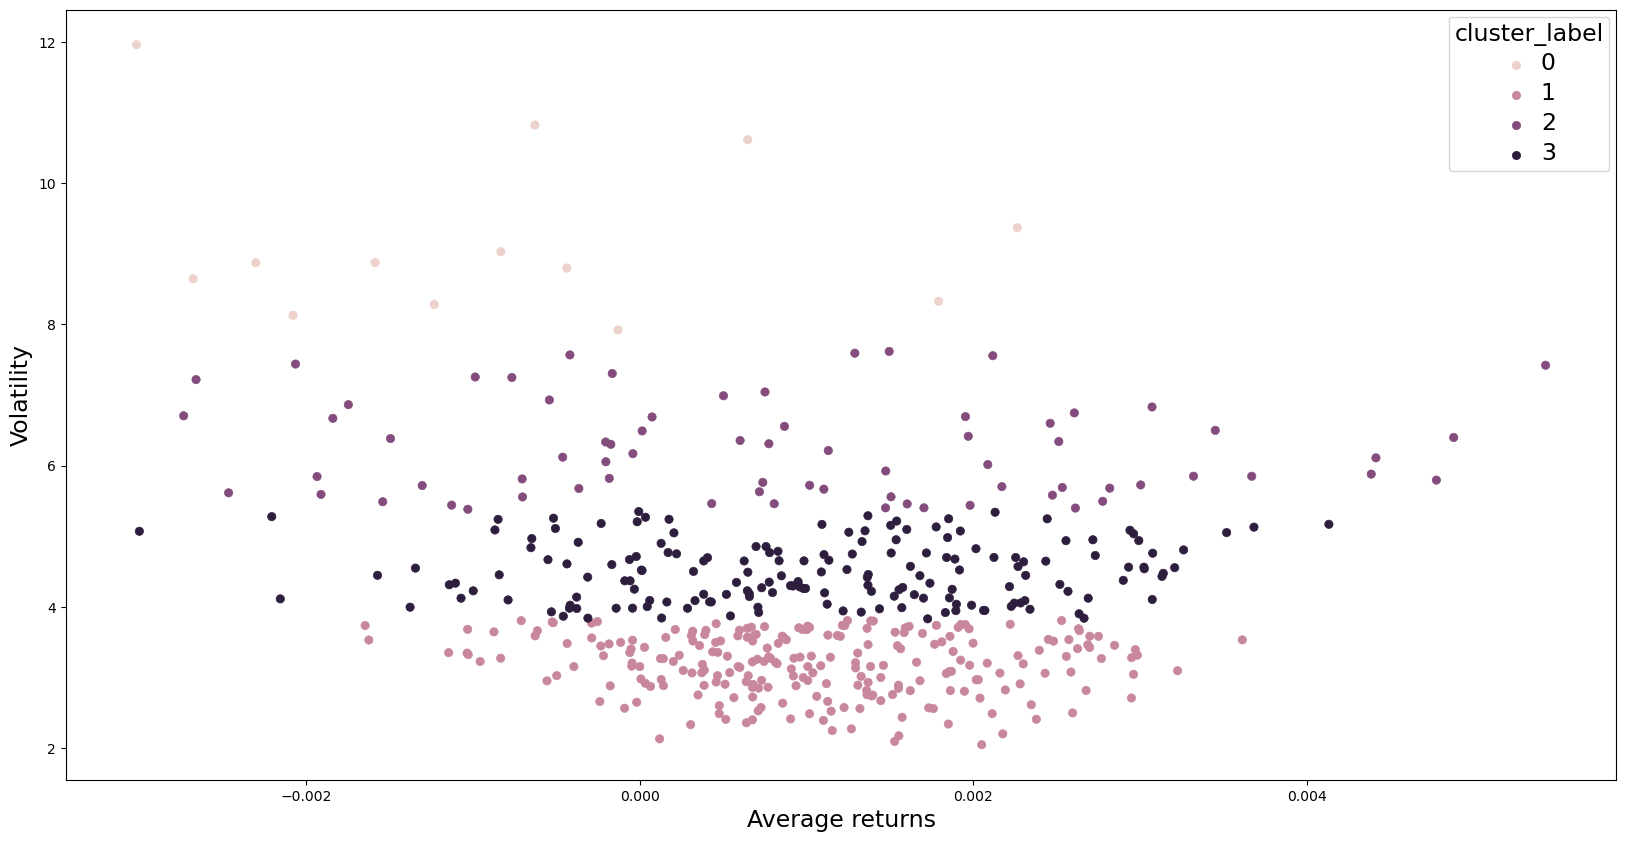

In [16]:
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(x="average_returns", y="volatility", edgecolor='face', hue="cluster_label",
                     data=df)
plt.xlabel('Average returns', size=17)
plt.ylabel('Volatility', size=17)
plt.setp(ax.get_legend().get_texts(), fontsize='17') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='17') # for legend title
plt.savefig('scatterplot', dpi=300) 

We remove the outliers.

In [17]:
#Removing outliers
no_outlier= pd.DataFrame(df).apply(pd.to_numeric) 
df_no_outlier = no_outlier.mask((no_outlier- no_outlier.mean()).abs() > 2 * no_outlier.std()).dropna()
df_no_outlier.columns = ['Average returns', 'Volatility', 'Cluster label']

Q: How where the outliers removed?


outliers were removed from df using a common method known as the Z-score method. The Z-score is a statistical measure that quantifies how many standard deviations a data point is from the mean of a group of data. 

In [37]:
df_average_returns = pd.DataFrame(average_returns)
df_average_returns.reset_index(level=0, inplace=True)

In [38]:
#We need to rename the second column (called "0") in order to have a 
#common column to perform the merge on.
 
df_average_returns.columns = ['index', 'average_returns']
 
#Let's merge. 
 
with_index = pd.merge(df_average_returns, df)
with_index.head()

,index,average_returns,volatility,cluster_label
0,A,0.001679,4.442753,3
1,AAL,0.000601,6.356351,2
2,AAPL,-0.000556,2.953490,1
3,ABBV,0.001760,2.561299,1
4,ABNB,0.001103,5.667505,2


Apply the Elbow method to select the optimal number of clusters. Plot the corresponding picture. 
(This method has been applied in a previous exercise.)

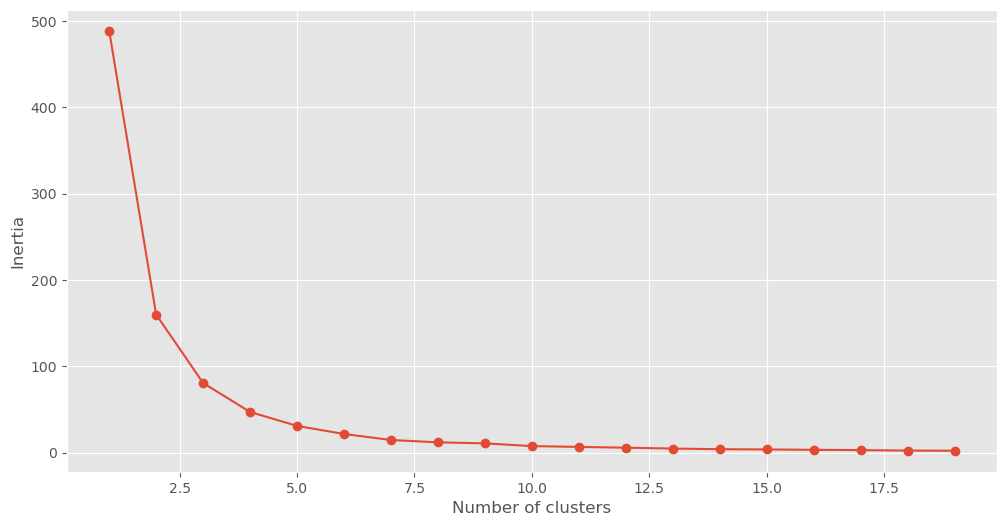

In [39]:
SSE = []
#rv_no_outliers = df_no_outlier['Average returns','Volatility']
rv_no_outliers = np.column_stack((df_no_outlier['Average returns'], df_no_outlier['Volatility']))
for cluster in range(1,20):
    km_res = KMeans(n_clusters = cluster, init='k-means++', n_init='auto')
    km_res.fit(rv_no_outliers)
    #km_res.fit(a_m_returns_volatility)
    SSE.append(km_res.inertia_)

frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.style.use('dark_background')

Present the size of each cluster as bars. You can use countplot in seaborn.

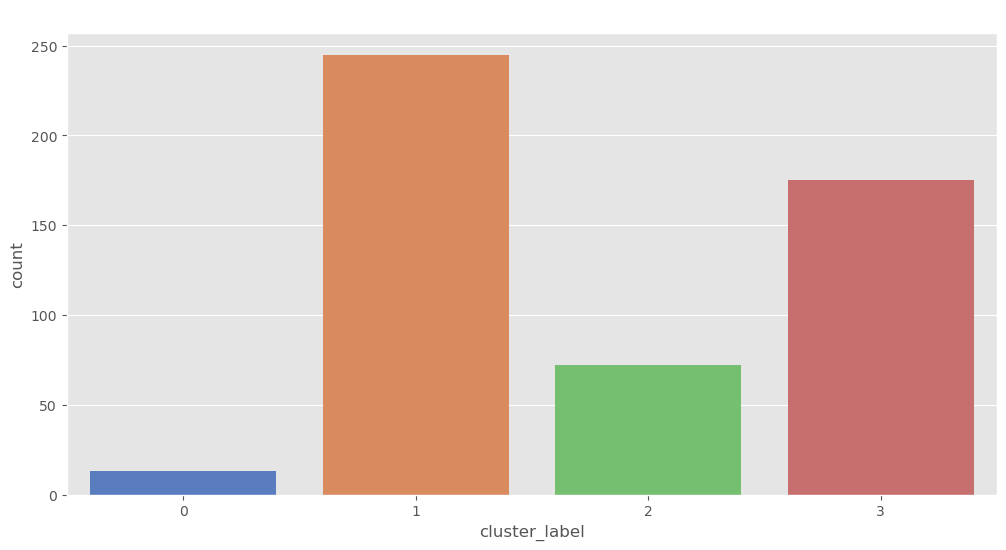

<Figure size 640x480 with 0 Axes>

In [21]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.countplot(x = 'cluster_label', data = with_index, 
              palette = 'muted', hue='cluster_label', edgecolor='none', legend=False)
plt.title('Cluster_count')
plt.show()
plt.savefig('cluster_count.png', dpi=300)


In [22]:
count_clusters = with_index["cluster_label"].value_counts().to_frame()
count_clusters.reset_index(level=0, inplace=True)
count_clusters.columns = ["cluster_label","nb"]

In [23]:
df_descriptive_stats = with_index.iloc[:, 1:4]
df_groupby_cluster = df_descriptive_stats.groupby(["cluster_label"], 
                                  as_index=False).mean()

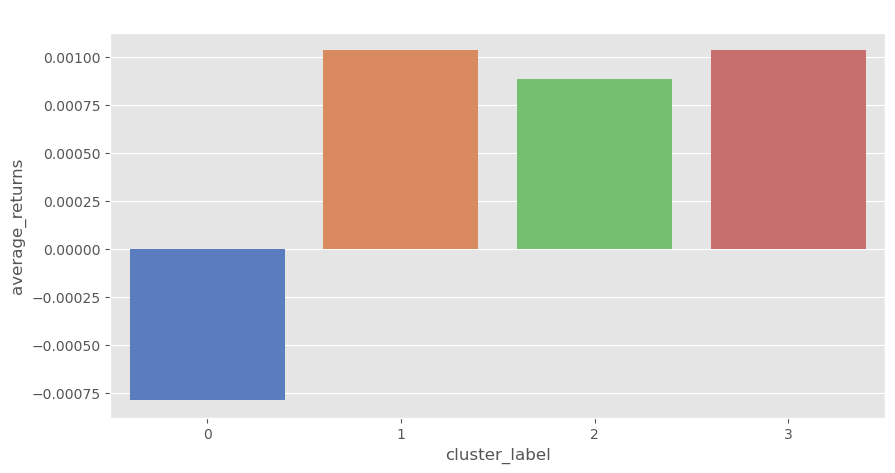

<Figure size 640x480 with 0 Axes>

In [24]:
plt.figure(figsize=(10,5))
sns.barplot(x = "cluster_label", y = "average_returns", data = df_groupby_cluster,  
              palette = 'muted', hue='cluster_label', edgecolor='none', legend=False)
plt.title("Average returns by cluster")
plt.show()
plt.savefig("returns_by_cluster.png", dpi=300)

How would you analyze the clustering based on the bar plots presented above?

average return for cluster 1-3 is roughly the same. however it's negative for cluster 0

<Axes: xlabel='cluster_label', ylabel='volatility'>

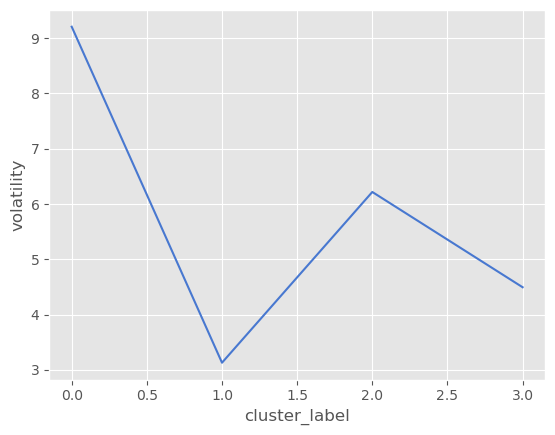

In [25]:
sns.lineplot(x="cluster_label", y="volatility", data=df_groupby_cluster, palette='muted', hue=0, legend=False)

Based on the bar charts above, how would you comment on the clustering? Is this a good clustering from the point of view of an investor? 

Clustering is useful for identifying peer groups among stocks, thus allowing differentiation between stocks with different levels of risk and return. This is useful for investors looking to diversify their investment portfolios
here it's a good clustering since volatility and returns pairs are different in each cluster.

<h4>Principal component analysis

In [26]:
from sklearn.decomposition import PCA

pca = PCA(1).fit(rs)

<Axes: title={'center': 'First Principal Component of the S&P500'}, xlabel='Ticker'>

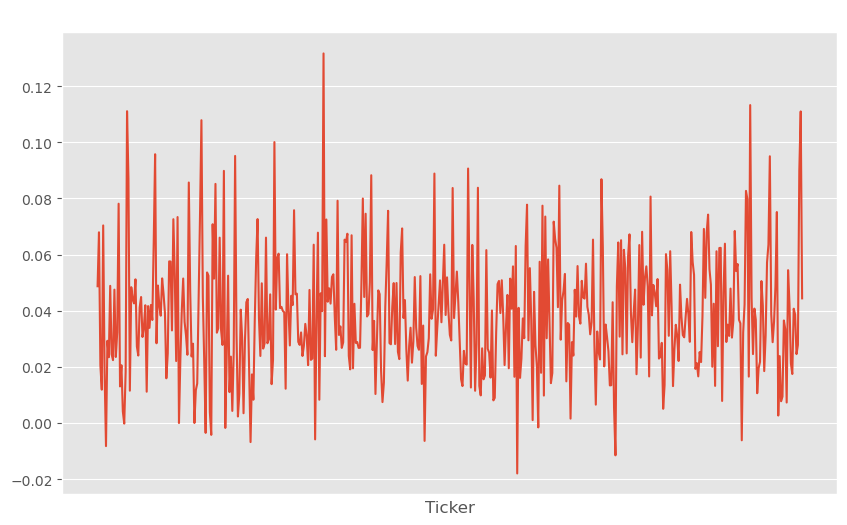

In [27]:
pc1 = pd.Series(index=rs.columns, data=pca.components_[0])

pc1.plot(figsize=(10,6), xticks=[], grid=True, title='First Principal Component of the S&P500')


<Axes: xlabel='Date'>

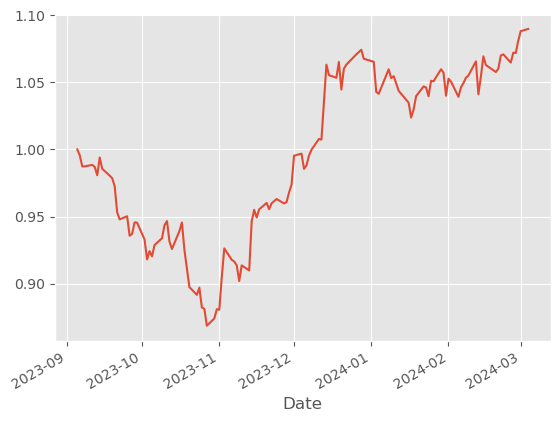

In [28]:
weights = abs(pc1)/sum(abs(pc1))
myrs = (weights*rs).sum(1)
myrs.cumsum().apply(np.exp).plot()

Compute the log-returns of these S&P 500 index closing prices. Form a dataframe rs_df with 2 columns, our weighted PCA portfolio 'myrs' and the S&P 500 index adjclosing prices. Name these columns "PCA Portfolio" and "S&P500". Plot the returns of "PCA Portfolio" and "S&P500".  (not the log-returns)  (code snippet in the end of the exercise)

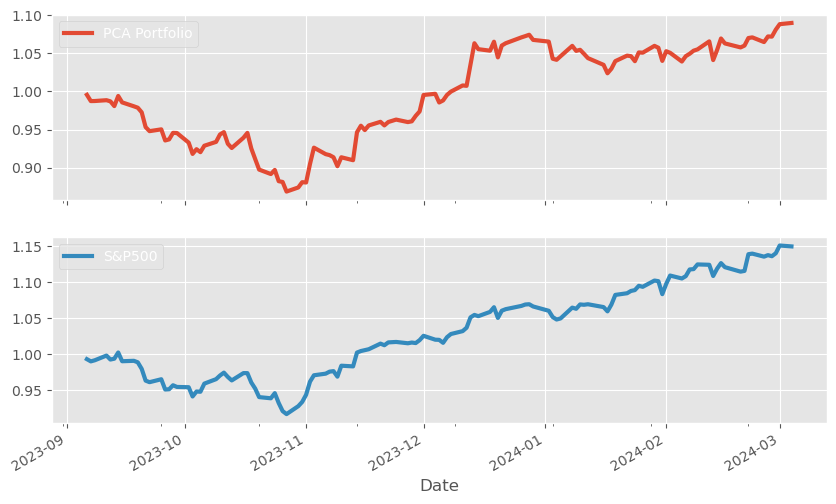

In [29]:
rs_df = pd.concat([myrs, prices_SPY.apply(np.log).diff(1)], axis=1)
rs_df.columns = ["PCA Portfolio", "S&P500"]

rs_df.dropna().cumsum().apply(np.exp).plot(subplots=True, figsize=(10,6), grid=True, linewidth=3)
plt.show()

<Axes: xlabel='Date'>

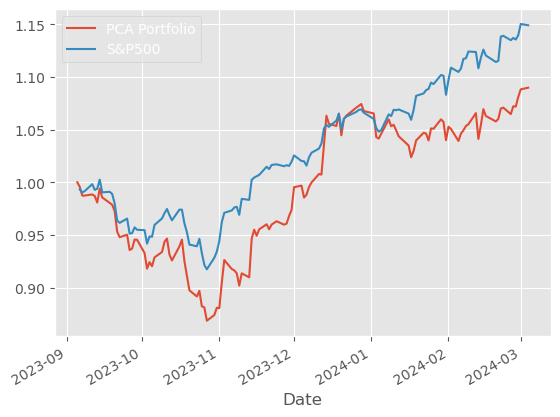

In [30]:
rs_df.cumsum().apply(np.exp).plot()

Using PCA, we can cluster together businesses that were most/least affected by the  current situation. 
1. Present with bars the 10 stocks that were the most affected the current situation. 
2. Present with bars the 10 stocks that were the least affected the current situation. 
You can use pandas.dataframe.nsmallest and nlargest. (code snippet in the end of the exercise)


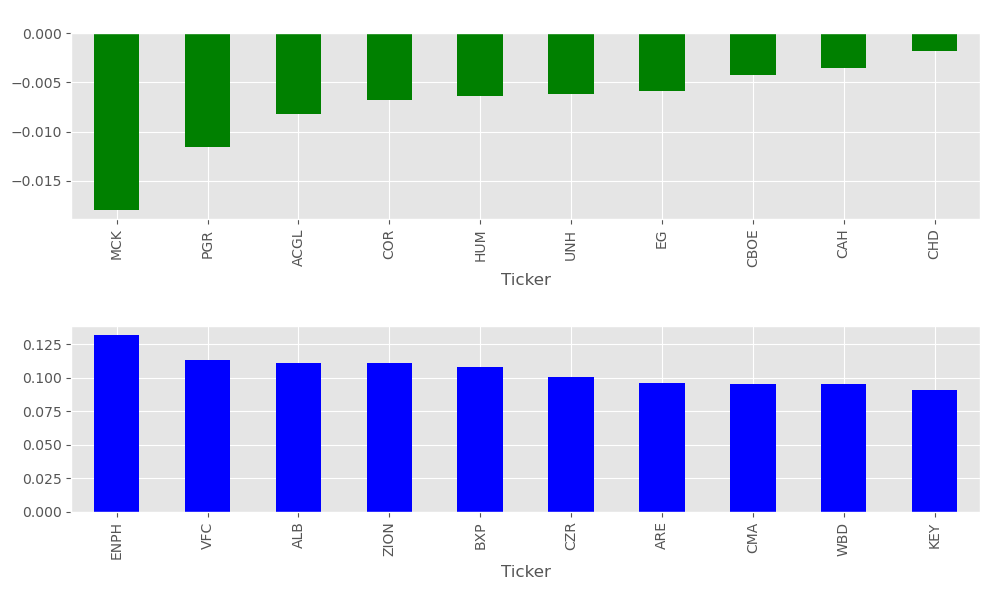

<Figure size 640x480 with 0 Axes>

In [31]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
pc1.nsmallest(10).plot.bar(ax=ax[0], color='green', grid=True, title='Stocks with Most Negative PCA Weights')
pc1.nlargest(10).plot.bar(ax=ax[1], color='blue', grid=True, title='Stocks with Least Negative PCA Weights')
plt.tight_layout()

plt.show()

plt.savefig('tmp.png')

In [32]:
pc1.nsmallest(10)

Ticker
MCK    -0.017975
PGR    -0.011520
ACGL   -0.008231
COR    -0.006792
HUM    -0.006381
UNH    -0.006163
EG     -0.005840
CBOE   -0.004227
CAH    -0.003519
CHD    -0.001753
dtype: float64

Using information on the 10 best performing and least performing stocks, how would you choose a winning portfolio of 10 stocks? How about a loosing portfolio? Plot the returns of such portfolios and compare them with the return of the S&P 500 index. (code in the end of the exercise) Note that your choice depends on the general trend of the index. 

we choose the 10 stocks that are most affected by the situation and form a winning portfolio.
and 10 smallest for loosing portfolio.

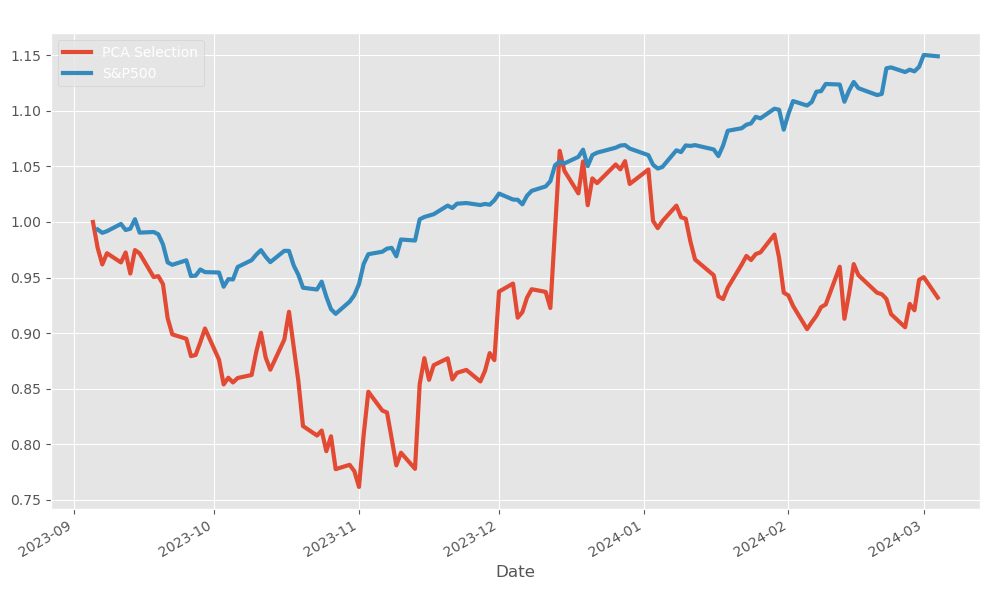

In [33]:
myrs = rs[pc1.nlargest(10).index].mean(1)
myrs.cumsum().apply(np.exp).plot(figsize=(15,5), grid=True, linewidth=3, title='PCA Portfolio vs. S&P500')
prices_SPY.apply(np.log).diff(1).cumsum().apply(np.exp).plot(figsize=(10,6), grid=True, linewidth=3)
plt.legend(['PCA Selection', 'S&P500'])

plt.tight_layout()
plt.savefig('tmp.png')

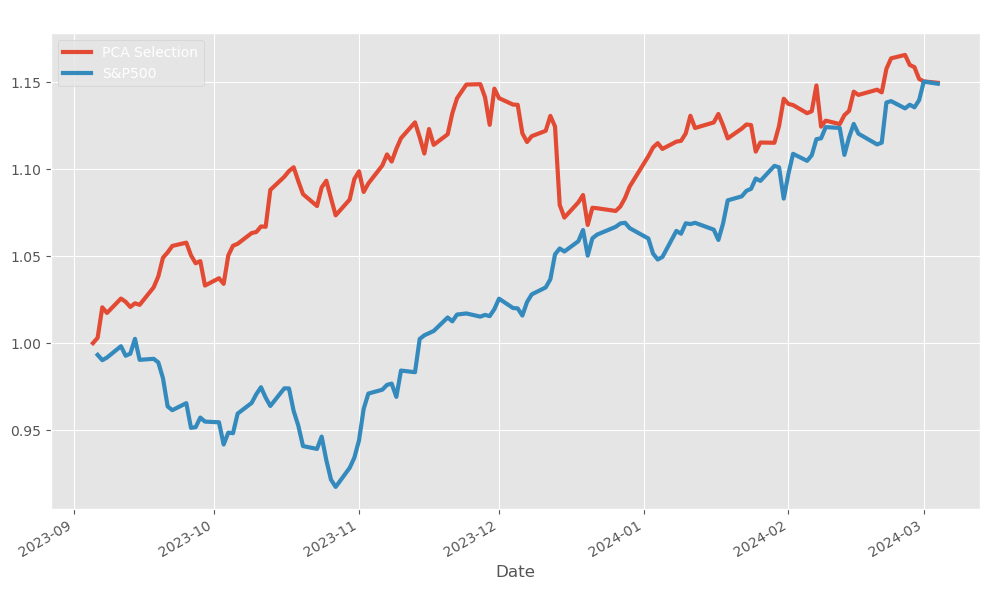

In [34]:
myrs = rs[pc1.nsmallest(10).index].mean(1)
myrs.cumsum().apply(np.exp).plot(figsize=(15,5), grid=True, linewidth=3, title='PCA Portfolio vs. S&P500')
prices_SPY.apply(np.log).diff(1).cumsum().apply(np.exp).plot(figsize=(10,6), grid=True, linewidth=3)
plt.legend(['PCA Selection', 'S&P500'])

plt.tight_layout()
plt.savefig('tmp.png')

Final questions: 

1. How could you use information provided by clustering the stocks based on the average return and volatility? You can think about portfolio allocation, trading strategies, risk management, and trends of different industries.
    
2. Repeat this exercise for different periods of time. Compare how well the first principal component PC1 tracks the S&P500 index. You will see that there is variation depending on the time period chosen. What kind of factors affect this variation? 

The extent to which the first principal component PC1 tracks the index provides information about the degree of correlation between the overall movement of the index and the dominant pattern of variability captured by PC1. How could we use information in our investment decisions?

1. we can use clusters for effective diversification by allocating assets with similar risk-return characteristics to the portfolio. eg we can develop intra-cluster trading strategies based on similar stock behavior within clusters, set cluster-specific stop-loss levels for effective risk management or customize hedging strategies based on the risk exposures of different clusters. Instead of using Return and Average Annualized Volatilite, we could also cluster based on Price-Earnings Ratio and Dividend Rate (Dividend Yield). In this way, we could differentiate between “value” companies and “growth” companies.

2. pca ability seem to depend on the volatility of the market.Volatility and market trends influence PC1's effectiveness, with high volatility and trending markets enhancing its tracking ability.Different economic cycles and changes in interest rates can impact how well PC1 tracks the S&P 500. also changes in market structure, corporate events, and other structural shifts can impact PC1's tracking accuracy. finally, assumptions underlying PCA, such as linearity and normality, may impact PC1's performance.

If PC1 closely tracks the index, it indicates a strong correlation with the overall market trend. Investors can use this information to identify whether the market is in an uptrend, downtrend, or sideways movement. eg they can increase exposure to the market during strong uptrends reflected in high PC1 correlation and reduce exposure or hedge positions during downtrends indicated by negative correlation. Conversely, if PC1 exhibits low correlation with the index, it may signal unique patterns or divergences. Investors employing contrarian strategies may seek opportunities when PC1 suggests a deviation from the overall market trend.

Code snippets

In [35]:
#rs_df = pd.concat([myrs, prices_SPY.apply(np.log).diff(1)], axis=1)
#rs_df.columns = ["PCA Portfolio", "S&P500"]

#rs_df.dropna().cumsum().apply(np.exp).plot(subplots=True, figsize=(10,6), grid=True, linewidth=3)
#plt.show()

In [36]:
#fig, ax = plt.subplots(2,1, figsize=(10,6))
#pc1.nsmallest(10).plot.bar(ax=ax[0], color='green', grid=True, title='Stocks with Most Negative PCA Weights')
#pc1.nlargest(10).plot.bar(ax=ax[1], color='blue', grid=True, title='Stocks with Least Negative PCA Weights')

#plt.tight_layout()
#plt.savefig('tmp.png')